In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

# Process Data

## 1. Load preprocessed images and tabular data
Several preprocessing steps were conducted on the raw images and tabular data - see notebook "data_preprocessing". 

In [2]:
images = np.load("../data/images/cleaned_images.npy")
tracks = np.load("../data/tracks/filtered_tracks.npy")
labels = np.load("../data/labels/filtered_y_train.npy")
labels_all = np.load("../data/labels/filtered_y_train_all_fates.npy")

print("Images shape: ", images.shape, "Tracks shape: ", tracks.shape, "Labels shape: ", labels.shape)

Images shape:  (1385, 1080, 2, 20, 20) Tracks shape:  (1385, 1080, 19) Labels shape:  (1385,)


### checking if data is the same

In [3]:
filtered_images_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_images.npy")
filtered_tracks_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_tracks.npy")
filtered_labels_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filteresd_y_train.npy")

In [4]:
np.unique(np.nonzero(images[:,0,:,:] != filtered_images_previous)[0])

array([], dtype=int64)

In [7]:
np.unique(np.nonzero(tracks[:,0,0:5] != filtered_tracks_previous[:,0:5])[0])

array([], dtype=int64)

## 2. Prepare for model training

### 1. FRET ratio calculation

In [5]:
fret_images = images[:,:,0,:,:] / images[:,:,1,:,:] #### DONOR / ACCEPTOR
fret_images = np.nan_to_num(fret_images, nan=0.0)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_1671/1128978299.py:1: RuntimeWarning: invalid value encountered in divide
  fret_images = images[:,:,0,:,:] / images[:,:,1,:,:] #### DONOR / ACCEPTOR


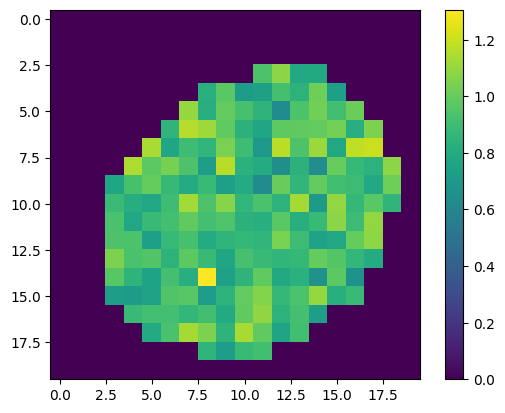

In [6]:
plt.imshow(fret_images[0,1001,:,:])
plt.colorbar()

### 2. Normalise images frame-wise

In [7]:
norm_images = normalize_images_per_frame(fret_images)

### 3. Center cells

In [8]:
centered_images = center_cells(norm_images)

In [9]:
from ipywidgets import interact, IntSlider

def display_movie(images, channel=0):
    cell = 900
    def plot_frame(frame):
        plt.imshow(images[cell, frame, :, :], cmap='gray')
        plt.title(f"Cell {cell}, Classification: {labels_all[cell]}")
        plt.axis('off')
        plt.show()

    # Create a slider for frame selection
    interact(plot_frame, frame=IntSlider(min=0, max=1079, step=1, value=0)) # max=images.shape[0] - 1

display_movie(centered_images)

interactive(children=(IntSlider(value=0, description='frame', max=1079), Output()), _dom_classes=('widget-inte…

### 4. Train-test split

In [10]:
train_indexes, test_indexes = train_test_split(
        np.arange(len(labels)),
        test_size=0.2,
        stratify=labels,
        random_state=42
    )
    
train_images = centered_images[train_indexes]
test_images = centered_images[test_indexes]

train_tracks = tracks[train_indexes]
test_tracks = tracks[test_indexes]

train_labels = labels[train_indexes]
test_labels = labels[test_indexes]

train_labels_all = labels_all[train_indexes]
test_labels_all = labels_all[test_indexes]


In [11]:
np.save("../data/images/train_images.npy", train_images)
np.save("../data/images/test_images.npy", test_images)
np.save("../data/labels/train_labels.npy", train_labels)
np.save("../data/labels/test_labels.npy", test_labels)
np.save("../data/tracks/train_tracks.npy", train_tracks)
np.save("../data/tracks/test_tracks.npy", test_tracks)

### 5. Data Augmentation

In [ ]:
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
# train_tracks = np.load("../data/tracks/train_tracks.npy")
# test_tracks = np.load("../data/tracks/test_tracks.npy")

In [3]:
import numpy as np

def augment_dataset(cell_images, labels, augmentations, augment_times=5, fate_0_label=0, fate_1_label=1, seed=42):
    """
    Augments a dataset of cell movies (cells, time, height, width), balances fate 0 and fate 1,
    and ensures reproducibility by setting a seed.

    Args:
        cell_images (numpy.ndarray): Array of shape (cells, time, height, width).
        labels (numpy.ndarray): 1D array of labels corresponding to cell fates.
        augmentations (function): Function that applies augmentations to a movie sequence.
        augment_times (int): Number of unique augmented copies per movie.
        fate_0_label (int): Label for fate 0 cells.
        fate_1_label (int): Label for fate 1 cells.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: Augmented and balanced (final_images, final_labels).
    """
    np.random.seed(seed)  # Ensure reproducibility

    # Separate fate 0 and fate 1 in the dataset
    fate_0_images = cell_images[labels == fate_0_label]
    fate_1_images = cell_images[labels == fate_1_label]

    # Generate multiple unique augmentations per movie
    augmented_fate_0 = np.concatenate([augmentations(movie, augment_times) for movie in fate_0_images], axis=0)
    augmented_fate_1 = np.concatenate([augmentations(movie, augment_times) for movie in fate_1_images], axis=0)

    # Combine original and augmented data
    fate_0_combined = np.concatenate([fate_0_images, augmented_fate_0], axis=0)
    fate_1_combined = np.concatenate([fate_1_images, augmented_fate_1], axis=0)

    # Balance fate 0 to match fate 1 count
    target_count = len(fate_1_combined)
    if len(fate_0_combined) < target_count:
        print("did this happen")
        extra_fate_0 = np.random.choice(len(fate_0_combined), size=target_count - len(fate_0_combined), replace=True)
        balanced_fate_0 = np.concatenate([fate_0_combined, fate_0_combined[extra_fate_0]], axis=0)
    else:
        balanced_fate_0 = fate_0_combined[np.random.choice(len(fate_0_combined), size=target_count, replace=False)]

    # Merge datasets
    final_images = np.concatenate([balanced_fate_0, fate_1_combined], axis=0)
    final_labels = np.array([fate_0_label] * len(balanced_fate_0) + [fate_1_label] * len(fate_1_combined))

    # Shuffle data
    shuffle_indexes = np.random.permutation(len(final_labels))
    final_images, final_labels = final_images[shuffle_indexes], final_labels[shuffle_indexes]

    return final_images, final_labels


def augmentations(movie, augment_times=4, seed=42):
    """
    Applies multiple **unique** augmentations to the whole movie (time-series of images).

    Args:
        movie (numpy.ndarray): Array of shape (time, height, width).
        augment_times (int): Number of unique augmented copies to generate.

    Returns:
        numpy.ndarray: Augmented movies (augment_times, time, height, width).
    """
    all_augmentations = [
        lambda x: np.flip(x, axis=-1),  # Flip horizontally
        lambda x: np.flip(x, axis=-2),  # Flip vertically
        lambda x: np.rot90(x, k=1, axes=(-2, -1)),  # Rotate 90 degrees
        lambda x: np.rot90(x, k=2, axes=(-2, -1)),  # Rotate 180 degrees
        lambda x: np.rot90(x, k=3, axes=(-2, -1))  # Rotate 270 degrees
    ]
    
    np.random.seed(seed)

    # Select random augmentations
    np.random.shuffle(all_augmentations)

    selected_augmentations = all_augmentations[:augment_times]

    # Apply selected augmentations
    augmented_movies = [augment(movie) for augment in selected_augmentations]

    return np.array(augmented_movies)  # Shape: (augment_times, time, height, width)

In [4]:
train_images_augmented, train_labels_augmented = augment_dataset(train_images, train_labels, augmentations)

In [5]:
train_images_augmented.shape, train_labels_augmented.shape

((2184, 1080, 20, 20), (2184,))

In [6]:
from ipywidgets import interact, IntSlider

def display_movie(images, channel=0):
    cell = 1092+182
    def plot_frame(frame):
        plt.imshow(images[cell, frame, :, :], cmap='gray')
        plt.title(f"Cell {cell}, Classification: {train_labels_augmented[cell]}")
        plt.axis('off')
        plt.show()

    # Create a slider for frame selection
    interact(plot_frame, frame=IntSlider(min=0, max=1079, step=1, value=0)) # max=images.shape[0] - 1

display_movie(train_images_augmented)

interactive(children=(IntSlider(value=0, description='frame', max=1079), Output()), _dom_classes=('widget-inte…

In [7]:
np.save("../data/images/train_images_augmented4.npy", train_images_augmented)
np.save("../data/labels/train_labels_augmented4.npy", train_labels_augmented)

In [ ]:
## FOR VISUALISATION PURPOSES ONLY ## - augment test set
# test_images_augmented, test_labels_augmented = augment_dataset(test_images, test_labels, augmentations)

### 6. Stretch image intensities in a frame-wise way
This is done to do a scaling of the intensities in each cell, so that the minimum value is 0 (but keeping the same "relationship" between pixel values)

In [5]:
stretched_x_train, stretched_x_test = stretch_intensities_global(train_images_augmented, test_images)

In [ ]:
# np.save("../data/images/stretched_x_test_augmented.npy", stretched_x_test_augmented)

In [ ]:
x_train = np.load('../data/images/train_images_augmented4_stretched.npy')
y_train = np.load('../data/labels/train_labels_augmented.npy')
x_test = np.load('../data/images/test_images_augmented4_stretched.npy')
y_test = np.load('../data/labels/test_labels.npy')

In [10]:
np.nonzero(stretched_x_train != x_train)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [9]:
np.save("../data/images/train_images_augmented4_stretched.npy", stretched_x_train)
np.save("../data/images/test_images_augmented4_stretched.npy", stretched_x_test)

print("Augmented images shape: ", stretched_x_train.shape, "Augmented labels shape: ", train_labels_augmented.shape, "Test images shape: ", stretched_x_test.shape, "Test labels shape: ", test_labels.shape, "Train tracks shape: ", train_tracks.shape, "Test tracks shape: ", test_tracks.shape)

Augmented images shape:  (2184, 1080, 20, 20) Augmented labels shape:  (2184,) Test images shape:  (277, 1080, 20, 20) Test labels shape:  (277,) Train tracks shape:  (1108, 1080, 19) Test tracks shape:  (277, 1080, 19)


### 7. Cell clock normalisation

In [3]:
image_x_train = np.load("../data/images/train_images_augmented4_stretched.npy")
image_x_test = np.load('../data/images/test_images_augmented4_stretched.npy')
track_x_train = np.load("../data/tracks/train_tracks.npy")
track_x_test = np.load("../data/tracks/test_tracks.npy")
y_train = np.load("../data/labels/train_labels.npy")
y_train_augmented = np.load('../data/labels/train_labels_augmented4.npy')
y_test = np.load('../data/labels/test_labels.npy')

In [ ]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data


def normalize_cell_time_images(images):
    """
    Normalize cell time by extracting images at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - images: numpy array of shape (cells, time, height, width)
      (assumes a cell's lifetime is determined by nonzero pixel values)
    
    Returns:
    - normalized_images: numpy array of shape (cells, 11, height, width)
    """
    num_cells, num_timepoints, height, width = images.shape
    normalized_images = np.zeros((num_cells, 11, height, width))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero frames)
        lifetime = np.count_nonzero(np.sum(images[i], axis=(1, 2)))  # Sum over spatial dims to check for zeros
        #print(lifetime)
        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract images at these indices
        normalized_images[i] = images[i, indices, :, :]

    return normalized_images



In [ ]:
time_norm_train_track = normalize_cell_time(track_x_train)
time_norm_test_track = normalize_cell_time(track_x_test)

time_norm_train_images = normalize_cell_time_images(image_x_train)
time_norm_test_images = normalize_cell_time_images(image_x_test)

In [12]:
np.save("../data/images/time_norm_train_images.npy", time_norm_train_images)
np.save("../data/images/time_norm_test_images.npy", time_norm_test_images)

In [11]:
np.nonzero(time_norm_train_images[:,0] != image_x_train[:,0])

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

# Model Workflow - Training and Evaluation

In [2]:
train_images_augmented = np.load('../data/images/time_norm_train_images.npy')
train_labels_augmented = np.load('../data/labels/train_labels_augmented4.npy')
test_images = np.load('../data/images/time_norm_test_images.npy')
test_labels = np.load('../data/labels/test_labels.npy')
train_tracks = np.load("../data/tracks/train_tracks.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

## Tabular Data

In [147]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

In [139]:
### removing features that would bias the model decision (i.e., the fate of the cell, mitosis time, etc.)

train_tracks_features = train_tracks[:, :, 4:17 ] #[4,14,15,16] all features : 4:17
test_tracks_features = test_tracks[:, :, 4:17]

print(train_tracks_features.shape)

(1108, 1080, 13)


### Simple MLP (No hidden layers)

In [140]:
def simple_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

Using the first frame

In [126]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = simple_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6074 - loss: 0.7646 - val_accuracy: 0.1522 - val_loss: 3.1772
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6041 - loss: 0.7584 - val_accuracy: 0.2826 - val_loss: 1.5749
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.6055 - loss: 0.7236 - val_accuracy: 0.4420 - val_loss: 1.0261
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6054 - loss: 0.7412 - val_accuracy: 0.5000 - val_loss: 0.8256
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6194 - loss: 0.6937 - val_accuracy: 0.5435 - val_loss: 0.7357
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6358 - loss: 0.6450 - val_accuracy: 0.5652 - val_loss: 0.7005
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.5987 - loss: 0.6822 - val_accuracy: 0.5652 - val_loss: 0.6853
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.6060 - loss: 0.6884 - val_accuracy: 0.58

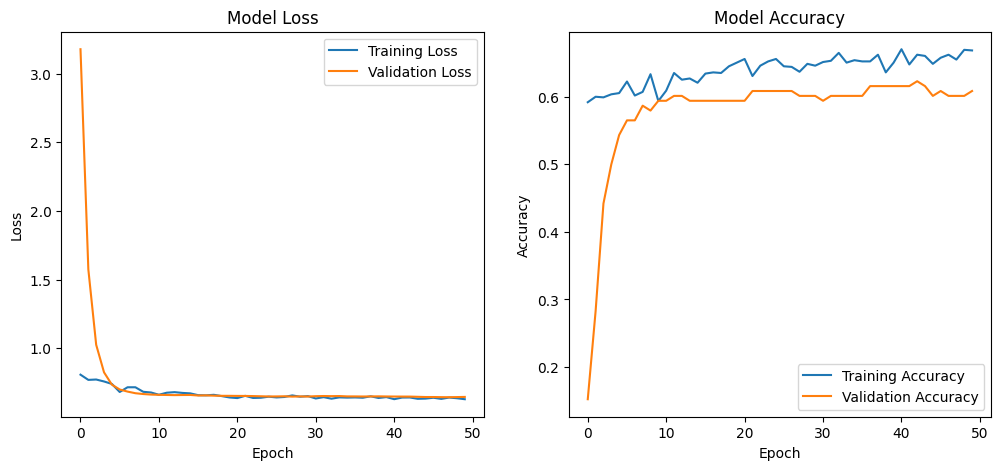

In [127]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[0.65765766 0.34234234]
 [0.5        0.5       ]]


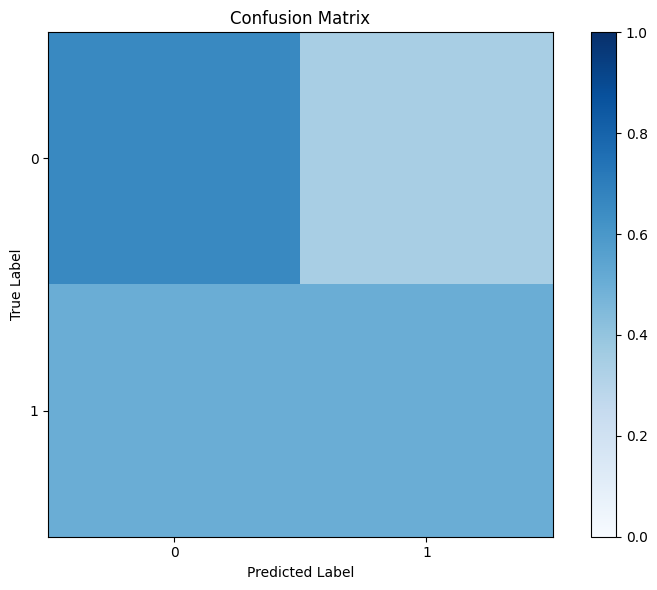

In [128]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### More Complex MLP 

In [149]:
def complex_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

In [157]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = complex_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_28          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6917 - loss: 0.7303 - val_accuracy: 0.8043 - val_loss: 0.5844
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.6965 - val_accuracy: 0.7754 - val_loss: 0.6551
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.5957 - loss: 0.6978 - val_accuracy: 0.4058 - val_loss: 0.7018
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.5555 - loss: 0.6974 - val_accuracy: 0.4420 - val_loss: 0.7032
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.5429 - loss: 0.6692 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.5491 - loss: 0.6744 - val_accuracy: 0.4710 - val_loss: 0.6805
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.5491 - loss: 0.6501 - val_accuracy: 0.4855 - val_loss: 0.6691
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.5449 - loss: 0.6531 - val_accuracy: 0.5435

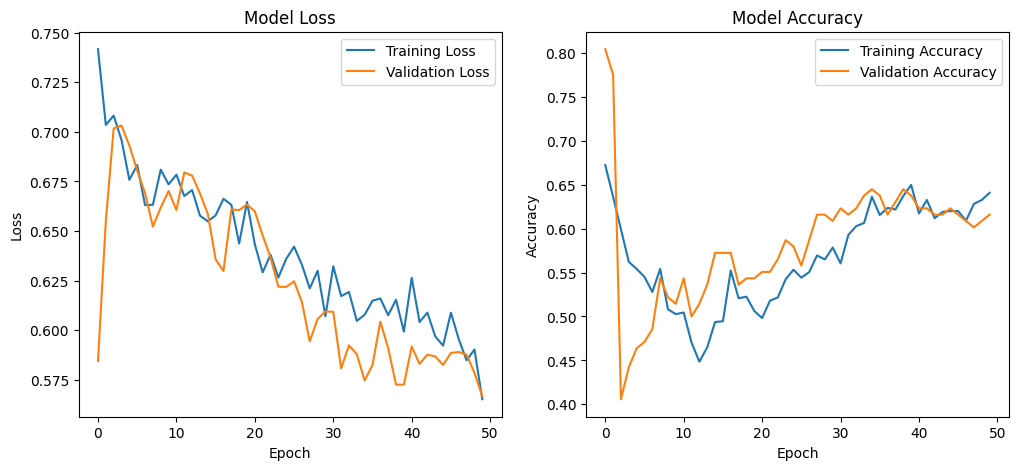

In [158]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[[0.63963964 0.36036036]
 [0.32142857 0.67857143]]
Precision:  0.6655507197857381


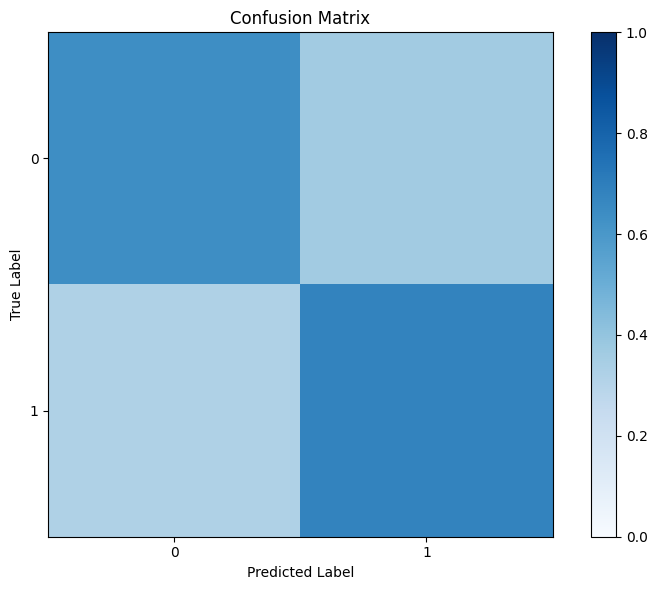

In [ ]:
num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
print("Precision: ", precision)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

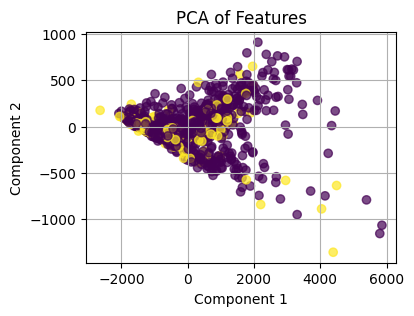

In [96]:
# Plot PCA of features to see if they are separable

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_tracks_features[:,frame,:])
X_pca = pca.transform(train_tracks_features[:,frame,:])

plt.figure(figsize=(4, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_labels.flatten(), cmap='viridis', alpha=0.7)
#sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train_labels.flatten())
plt.title('PCA of Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

#### Temporal study

In [141]:
train_tracks_features = train_tracks[:, :, 4:17 ]
test_tracks_features = test_tracks[:, :, 4:17 ]

In [142]:
train_tracks_features.shape

(1108, 1080, 13)

In [ ]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data



In [144]:
time_norm_train_track = normalize_cell_time(train_tracks_features)
time_norm_test_track = normalize_cell_time(test_tracks_features)

In [145]:
time_norm_train_track.shape, time_norm_test_track.shape

((1108, 11, 13), (277, 11, 13))

In [152]:
precisions = np.zeros((11, 1))
mean_diagonals = np.zeros((11, 1))

for i in range(11):
    frame = i
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
    class_weights = dict(enumerate(class_weights))

    tf.keras.utils.set_random_seed(config['seed'])

    classifier = complex_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1]) #[:, [3, 8]] 
    #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

    # Train the classifier
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
    classifier.summary()

    x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(time_norm_test_track[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

    history = classifier.fit(time_norm_train_track[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

    y_pred = classifier.predict(x_test_tracks)

    num_classes = len(np.unique(train_labels))
    threshold = 0.5
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_tracks, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    print(conf_matrix_normalized)

    precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
    mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
    print("frame", frame, "Precision: ", precision, "Mean diagonal: ", mean_diagonal)

    precisions[i] = precision
    mean_diagonals[i] = mean_diagonal


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6777 - loss: 0.7542 - val_accuracy: 0.8043 - val_loss: 0.5931
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6072 - loss: 0.7059 - val_accuracy: 0.8188 - val_loss: 0.6393
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5235 - loss: 0.7127 - val_accuracy: 0.5290 - val_loss: 0.6843
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5351 - loss: 0.6937 - val_accuracy: 0.5072 - val_loss: 0.6876
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5121 - loss: 0.6792 - val_accuracy: 0.4638 - val_loss: 0.6797
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5070 - loss: 0.6980 - val_accuracy: 0.4928 - val_loss: 0.6750
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5357 - loss: 0.6572 - val_accuracy: 0.4928 - val_loss: 0.6700
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5343 - loss: 0.6672 - val_accuracy: 0.5217

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6620 - loss: 0.7621 - val_accuracy: 0.8406 - val_loss: 0.5748
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.6045 - loss: 0.7042 - val_accuracy: 0.8478 - val_loss: 0.6164
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.5732 - loss: 0.7201 - val_accuracy: 0.5942 - val_loss: 0.6813
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5113 - loss: 0.7011 - val_accuracy: 0.4493 - val_loss: 0.6988
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.5064 - loss: 0.6778 - val_accuracy: 0.4203 - val_loss: 0.7034
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.5187 - loss: 0.6883 - val_accuracy: 0.4710 - val_loss: 0.6892
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5451 - loss: 0.6602 - val_accuracy: 0.5072 - val_loss: 0.6858
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5391 - loss: 0.6772 - val_accuracy: 0.52

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6857 - loss: 0.7701 - val_accuracy: 0.8623 - val_loss: 0.5417
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.6348 - loss: 0.7036 - val_accuracy: 0.8623 - val_loss: 0.5888
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.5570 - loss: 0.7205 - val_accuracy: 0.6594 - val_loss: 0.6566
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5512 - loss: 0.6911 - val_accuracy: 0.5652 - val_loss: 0.6685
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5497 - loss: 0.6725 - val_accuracy: 0.5725 - val_loss: 0.6570
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5489 - loss: 0.6831 - val_accuracy: 0.5942 - val_loss: 0.6433
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5871 - loss: 0.6348 - val_accuracy: 0.5580 - val_loss: 0.6461
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5346 - loss: 0.6659 - val_accuracy: 0.57

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6767 - loss: 0.7681 - val_accuracy: 0.8623 - val_loss: 0.5357
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6508 - loss: 0.7035 - val_accuracy: 0.8551 - val_loss: 0.5954
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.5889 - loss: 0.7111 - val_accuracy: 0.6087 - val_loss: 0.6610
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5563 - loss: 0.6876 - val_accuracy: 0.5362 - val_loss: 0.6706
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.5147 - loss: 0.6733 - val_accuracy: 0.5290 - val_loss: 0.6687
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.5649 - loss: 0.6762 - val_accuracy: 0.5652 - val_loss: 0.6510
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.5921 - loss: 0.6500 - val_accuracy: 0.5290 - val_loss: 0.6613
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5741 - loss: 0.6515 - val_accuracy: 0.5290

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6924 - loss: 0.7617 - val_accuracy: 0.8623 - val_loss: 0.5276
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.6368 - loss: 0.7056 - val_accuracy: 0.8188 - val_loss: 0.6017
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.5874 - loss: 0.7145 - val_accuracy: 0.6304 - val_loss: 0.6562
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5489 - loss: 0.6916 - val_accuracy: 0.5652 - val_loss: 0.6619
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.5669 - loss: 0.6675 - val_accuracy: 0.5797 - val_loss: 0.6657
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.5641 - loss: 0.6707 - val_accuracy: 0.5580 - val_loss: 0.6633
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5762 - loss: 0.6275 - val_accuracy: 0.5797 - val_loss: 0.6544
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5694 - loss: 0.6484 - val_accuracy: 0.60

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6981 - loss: 0.7527 - val_accuracy: 0.8623 - val_loss: 0.5340
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.7045 - val_accuracy: 0.8478 - val_loss: 0.5831
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.5710 - loss: 0.7140 - val_accuracy: 0.6884 - val_loss: 0.6302
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5523 - loss: 0.6935 - val_accuracy: 0.6884 - val_loss: 0.6402
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.5520 - loss: 0.6726 - val_accuracy: 0.6232 - val_loss: 0.6487
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5667 - loss: 0.6733 - val_accuracy: 0.6159 - val_loss: 0.6360
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5883 - loss: 0.6349 - val_accuracy: 0.6087 - val_loss: 0.6432
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5560 - loss: 0.6585 - val_accuracy: 0.6087

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6959 - loss: 0.7580 - val_accuracy: 0.8696 - val_loss: 0.5371
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.7025 - val_accuracy: 0.8696 - val_loss: 0.5694
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.5986 - loss: 0.7078 - val_accuracy: 0.7101 - val_loss: 0.6166
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.5911 - loss: 0.6804 - val_accuracy: 0.6377 - val_loss: 0.6265
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.5726 - loss: 0.6709 - val_accuracy: 0.5870 - val_loss: 0.6228
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5905 - loss: 0.6584 - val_accuracy: 0.5870 - val_loss: 0.6076
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5821 - loss: 0.6286 - val_accuracy: 0.6014 - val_loss: 0.6062
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.6028 - loss: 0.6360 - val_accuracy: 0.6159

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6845 - loss: 0.7527 - val_accuracy: 0.8696 - val_loss: 0.5113
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6332 - loss: 0.7010 - val_accuracy: 0.8623 - val_loss: 0.5679
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6050 - loss: 0.7119 - val_accuracy: 0.6812 - val_loss: 0.6292
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5356 - loss: 0.6870 - val_accuracy: 0.6014 - val_loss: 0.6468
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.5347 - loss: 0.6829 - val_accuracy: 0.5797 - val_loss: 0.6521
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5486 - loss: 0.6831 - val_accuracy: 0.5725 - val_loss: 0.6422
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5760 - loss: 0.6458 - val_accuracy: 0.5725 - val_loss: 0.6426
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5811 - loss: 0.6452 - val_accuracy: 0.6014

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_9           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6925 - loss: 0.7463 - val_accuracy: 0.8623 - val_loss: 0.5436
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6524 - loss: 0.6977 - val_accuracy: 0.8478 - val_loss: 0.6089
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.6101 - loss: 0.7048 - val_accuracy: 0.6014 - val_loss: 0.6547
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5578 - loss: 0.6951 - val_accuracy: 0.5072 - val_loss: 0.6523
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5378 - loss: 0.6784 - val_accuracy: 0.5000 - val_loss: 0.6517
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5586 - loss: 0.6874 - val_accuracy: 0.5507 - val_loss: 0.6355
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5570 - loss: 0.6478 - val_accuracy: 0.5942 - val_loss: 0.6371
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5591 - loss: 0.6556 - val_accuracy: 0.5942

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7012 - loss: 0.7499 - val_accuracy: 0.8623 - val_loss: 0.5660
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.6135 - loss: 0.7068 - val_accuracy: 0.7826 - val_loss: 0.6303
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.5641 - loss: 0.7148 - val_accuracy: 0.5072 - val_loss: 0.6892
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.5295 - loss: 0.7008 - val_accuracy: 0.4565 - val_loss: 0.6946
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5438 - loss: 0.6869 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5523 - loss: 0.6843 - val_accuracy: 0.5290 - val_loss: 0.6692
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5654 - loss: 0.6543 - val_accuracy: 0.5435 - val_loss: 0.6621
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5706 - loss: 0.6570 - val_accuracy: 0.56

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7119 - loss: 0.7453 - val_accuracy: 0.8696 - val_loss: 0.4989
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6307 - loss: 0.7011 - val_accuracy: 0.8696 - val_loss: 0.5986
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.5983 - loss: 0.7137 - val_accuracy: 0.6304 - val_loss: 0.6604
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.5342 - loss: 0.6981 - val_accuracy: 0.5580 - val_loss: 0.6744
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.5542 - loss: 0.6956 - val_accuracy: 0.5145 - val_loss: 0.6774
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.5679 - loss: 0.6848 - val_accuracy: 0.5725 - val_loss: 0.6637
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.6013 - loss: 0.6571 - val_accuracy: 0.5870 - val_loss: 0.6502
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5656 - loss: 0.6621 - val_accuracy: 0.5797

In [153]:
conf_matrix_normalized

array([[0.64864865, 0.35135135],
       [0.14285714, 0.85714286]])

In [154]:
precisions

array([[0.61615844],
       [0.6711554 ],
       [0.72456576],
       [0.74715262],
       [0.74004684],
       [0.74715262],
       [0.80340064],
       [0.83457526],
       [0.85298013],
       [0.77932406],
       [0.8195122 ]])

In [160]:
mean_diagonals

array([[0.61888674],
       [0.70447233],
       [0.70382883],
       [0.74436937],
       [0.73085586],
       [0.74436937],
       [0.77557915],
       [0.78893179],
       [0.75723938],
       [0.7260296 ],
       [0.75289575]])

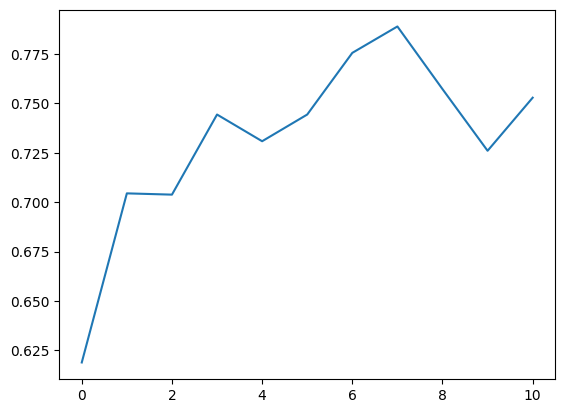

In [156]:
plt.plot(mean_diagonals)

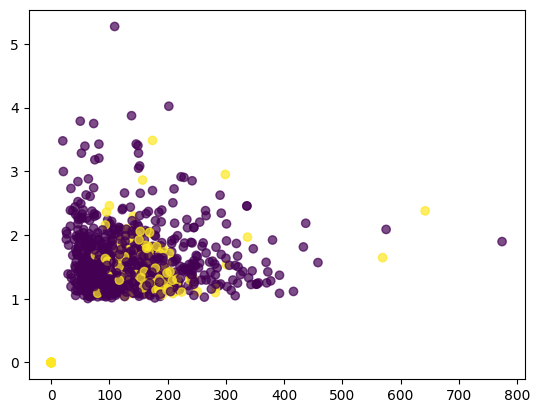

In [63]:
plt.scatter(time_norm_train_track[:,10,2], time_norm_train_track[:,10,3], c=train_labels.flatten(), cmap='viridis', alpha=0.7)

## Image Data

### Full CellFate Workflow 

#### 1. Train Adversarial Autoencoder (AAE)

In [3]:
config = {
        'batch_size': 30,
        'epochs': 15,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 5,
        'lambda_adv': 1,
    }

In [4]:
autoencoder_results = train_autoencoder(config, train_images_augmented[:,0,:,:])

encoder = autoencoder_results['encoder']
decoder = autoencoder_results['decoder']
discriminator = autoencoder_results['discriminator']
reconstruction_losses = autoencoder_results['recon_loss']
adversarial_losses = autoencoder_results['adv_loss']


Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

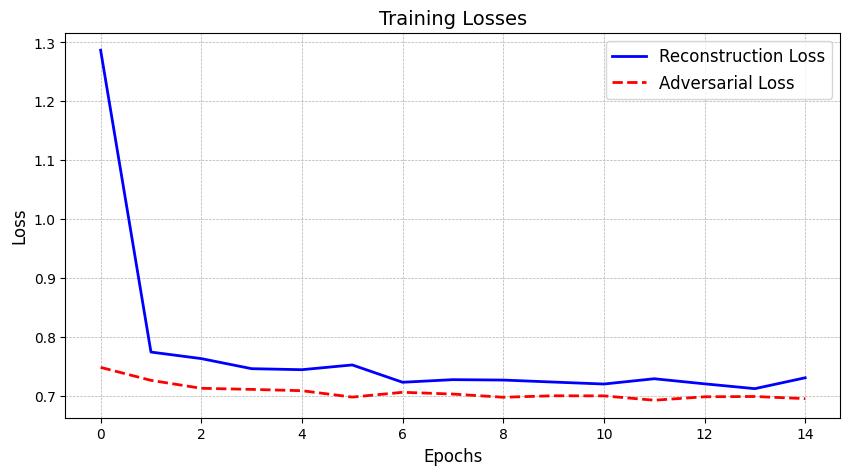

In [5]:
plt.figure(figsize=(10, 5))

plt.plot(reconstruction_losses, label='Reconstruction Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(adversarial_losses, label='Adversarial Loss', color='red', linestyle='--', linewidth=2)

# Title and labels
plt.title(f"Training Losses", fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add a grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', fontsize=12)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


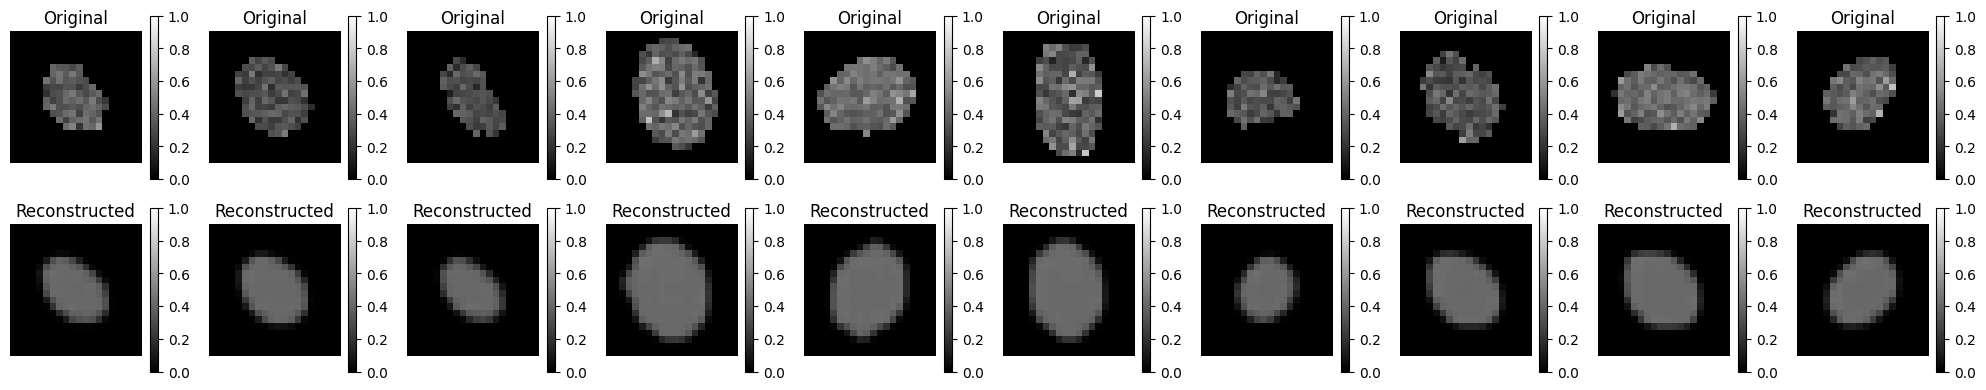

In [6]:
z_imgs = encoder.predict(train_images_augmented[:,0,:,:])
recon_imgs = decoder.predict(z_imgs)

reconstruction_images(train_images_augmented[:,0,:,:], recon_imgs)

Top correlated features: 1, 0


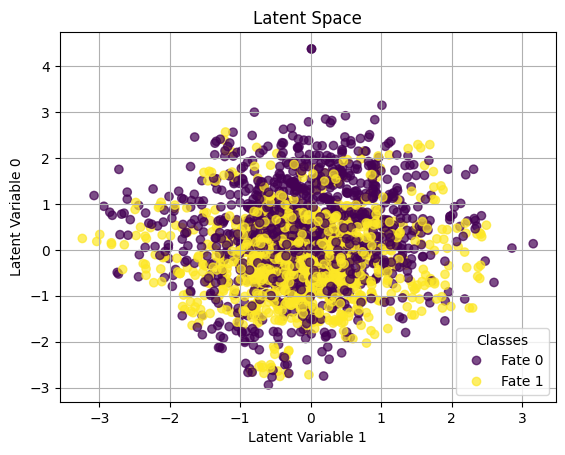

In [8]:
visualize_latent_space(z_imgs, train_labels_augmented)

#### 2. Train AAE with Contrastive loss and Covariance loss

In [9]:
config = {
        'batch_size': 30,
        'epochs': 100,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 6,
        'lambda_adv': 4,
        'lambda_cov': 0.0001,
        'lambda_contra': 8,
    }

In [10]:
cellfate_results = train_cellfate(config, encoder, decoder, discriminator, train_images_augmented[:,0,:,:], train_labels_augmented, test_images[:,0,:,:], test_labels) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
encoder = cellfate_results['encoder']
decoder = cellfate_results['decoder']
discriminator = cellfate_results['discriminator']
reconstruction_losses = cellfate_results['recon_loss']
adversarial_losses = cellfate_results['adv_loss']
cov_losses = cellfate_results['cov_loss']
contra_losses = cellfate_results['contra_loss']

Training with batch size: 30, epochs: 100, learning rate: 0.001, seed: 42, latent dim: 2
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/100: Reconstruction loss: 0.8974, Adversarial loss: 2.8218, Contrastive loss: 5.4767, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 2/100: Reconstruction loss: 0.9062, Adversarial loss: 2.8233, Contrastive loss: 5.3505, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 3/100: Reconstruction loss: 0.9729, Adversarial loss: 2.8074, Contrastive loss: 5.3459, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5844 - loss: 0.6921 - val_accuracy: 0.5942 - val_loss: 0.6591
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.6283 - loss: 0.6695 - val_accuracy: 0.6014 - val_loss: 0.6453
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.6356 - loss: 0.6498 - val_accuracy: 0.5942 - val_loss: 0.6362
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.6315 - loss: 0.6606 - val_accuracy: 0.5797 - val_loss: 0.6289
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.6556 - loss: 0.6268 - val_accuracy: 0.5797 - val_loss: 0.6252
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.6162 - loss: 0.6416 - val_accuracy: 0.5797 - val_loss: 0.6233
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.6611 - loss: 0.6181 - val_accuracy: 0.5725 - val_loss: 0.6270
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.6284 - loss: 0.6307 - val_accuracy: 0.57

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6505 - loss: 0.6165 - val_accuracy: 0.7609 - val_loss: 0.6067
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6766 - loss: 0.5956 - val_accuracy: 0.7464 - val_loss: 0.6025
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.6408 - loss: 0.6220 - val_accuracy: 0.7319 - val_loss: 0.5995
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6581 - loss: 0.6135 - val_accuracy: 0.7319 - val_loss: 0.5988
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.6554 - loss: 0.6126 - val_accuracy: 0.7319 - val_loss: 0.6001
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6642 - loss: 0.6041 - val_accuracy: 0.7319 - val_loss: 0.6005
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.6488 - loss: 0.6110 - val_accuracy: 0.7319 - val_loss: 0.5995
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.6543 - loss: 0.6117 - val_accuracy: 0.7319

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 0.6751 - val_accuracy: 0.7101 - val_loss: 0.6452
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.6535 - loss: 0.6835 - val_accuracy: 0.7174 - val_loss: 0.6205
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.6645 - loss: 0.6483 - val_accuracy: 0.7246 - val_loss: 0.6025
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6712 - loss: 0.6452 - val_accuracy: 0.7246 - val_loss: 0.5870
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.6659 - loss: 0.6170 - val_accuracy: 0.7246 - val_loss: 0.5779
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6866 - loss: 0.6101 - val_accuracy: 0.7391 - val_loss: 0.5712
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.6738 - loss: 0.6070 - val_accuracy: 0.7464 - val_loss: 0.5655
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6818 - loss: 0.5960 - val_accuracy: 0.75

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4964 - loss: 0.7057 - val_accuracy: 0.6377 - val_loss: 0.6697
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.6060 - loss: 0.6685 - val_accuracy: 0.6232 - val_loss: 0.6615
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6404 - loss: 0.6499 - val_accuracy: 0.6522 - val_loss: 0.6523
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.6582 - loss: 0.6338 - val_accuracy: 0.6739 - val_loss: 0.6419
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.6747 - loss: 0.6285 - val_accuracy: 0.6812 - val_loss: 0.6339
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.6614 - loss: 0.6206 - val_accuracy: 0.6884 - val_loss: 0.6263
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.6633 - loss: 0.6169 - val_accuracy: 0.6884 - val_loss: 0.6195
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.6654 - loss: 0.6189 - val_accuracy: 0.70

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3573 - loss: 1.1115 - val_accuracy: 0.2899 - val_loss: 1.0772
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.4064 - loss: 1.0129 - val_accuracy: 0.3043 - val_loss: 0.9782
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.4219 - loss: 0.9291 - val_accuracy: 0.3116 - val_loss: 0.8917
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.4188 - loss: 0.8661 - val_accuracy: 0.3406 - val_loss: 0.8162
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.4045 - loss: 0.8123 - val_accuracy: 0.4203 - val_loss: 0.7562
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.4388 - loss: 0.7610 - val_accuracy: 0.4493 - val_loss: 0.7132
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.4915 - loss: 0.7180 - val_accuracy: 0.5217 - val_loss: 0.6770
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.5211 - loss: 0.6941 - val_accuracy: 0.63

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5134 - loss: 0.9232 - val_accuracy: 0.4058 - val_loss: 0.9529
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.5297 - loss: 0.8562 - val_accuracy: 0.4565 - val_loss: 0.8799
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.5568 - loss: 0.8064 - val_accuracy: 0.4855 - val_loss: 0.8159
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5598 - loss: 0.7678 - val_accuracy: 0.5072 - val_loss: 0.7681
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.5706 - loss: 0.7380 - val_accuracy: 0.5362 - val_loss: 0.7258
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.5926 - loss: 0.7016 - val_accuracy: 0.5580 - val_loss: 0.6934
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.5905 - loss: 0.6948 - val_accuracy: 0.5797 - val_loss: 0.6691
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.6295 - loss: 0.6500 - val_accuracy: 0.6014

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5822 - loss: 0.8852 - val_accuracy: 0.5217 - val_loss: 0.8075
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.5979 - loss: 0.8311 - val_accuracy: 0.5290 - val_loss: 0.7731
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.6020 - loss: 0.7898 - val_accuracy: 0.5435 - val_loss: 0.7447
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.6106 - loss: 0.7571 - val_accuracy: 0.5580 - val_loss: 0.7191
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.6234 - loss: 0.7236 - val_accuracy: 0.5725 - val_loss: 0.6913
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6157 - loss: 0.7025 - val_accuracy: 0.6087 - val_loss: 0.6721
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.6227 - loss: 0.6749 - val_accuracy: 0.6232 - val_loss: 0.6543
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.6334 - loss: 0.6582 - val_accuracy: 0.62

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4541 - loss: 0.7435 - val_accuracy: 0.5507 - val_loss: 0.6984
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.5511 - loss: 0.7054 - val_accuracy: 0.5290 - val_loss: 0.6951
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6199 - loss: 0.6743 - val_accuracy: 0.5652 - val_loss: 0.6878
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6244 - loss: 0.6588 - val_accuracy: 0.5797 - val_loss: 0.6791
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.6595 - loss: 0.6415 - val_accuracy: 0.6159 - val_loss: 0.6691
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.6338 - loss: 0.6381 - val_accuracy: 0.6449 - val_loss: 0.6596
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.6474 - loss: 0.6323 - val_accuracy: 0.6522 - val_loss: 0.6498
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6608 - loss: 0.6206 - val_accuracy: 0.65

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.6660 - val_accuracy: 0.5725 - val_loss: 0.7714
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6484 - loss: 0.6746 - val_accuracy: 0.6014 - val_loss: 0.7311
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.6599 - loss: 0.6447 - val_accuracy: 0.6014 - val_loss: 0.7010
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.6652 - loss: 0.6185 - val_accuracy: 0.6159 - val_loss: 0.6760
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.6642 - loss: 0.6249 - val_accuracy: 0.6594 - val_loss: 0.6548
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.6607 - loss: 0.6134 - val_accuracy: 0.6667 - val_loss: 0.6401
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.6540 - loss: 0.6190 - val_accuracy: 0.6739 - val_loss: 0.6314
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.6645 - loss: 0.6077 - val_accuracy: 0.6667

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6034 - loss: 0.7713 - val_accuracy: 0.5725 - val_loss: 0.8005
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.6190 - loss: 0.7168 - val_accuracy: 0.5942 - val_loss: 0.7434
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6381 - loss: 0.6898 - val_accuracy: 0.6377 - val_loss: 0.6934
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.6324 - loss: 0.6647 - val_accuracy: 0.6522 - val_loss: 0.6531
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.6437 - loss: 0.6563 - val_accuracy: 0.6522 - val_loss: 0.6237
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.6444 - loss: 0.6475 - val_accuracy: 0.6739 - val_loss: 0.6011
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.6392 - loss: 0.6226 - val_accuracy: 0.6957 - val_loss: 0.5845
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.6275 - loss: 0.6353 - val_accuracy: 0.70

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6476 - loss: 0.6639 - val_accuracy: 0.6159 - val_loss: 0.7421
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.6571 - loss: 0.6230 - val_accuracy: 0.6304 - val_loss: 0.6916
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6781 - loss: 0.5991 - val_accuracy: 0.6377 - val_loss: 0.6552
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6797 - loss: 0.5944 - val_accuracy: 0.6377 - val_loss: 0.6287
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6621 - loss: 0.6046 - val_accuracy: 0.6667 - val_loss: 0.6079
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6579 - loss: 0.5919 - val_accuracy: 0.6739 - val_loss: 0.5991
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.6586 - loss: 0.5965 - val_accuracy: 0.6739 - val_loss: 0.5921
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6591 - loss: 0.5828 - val_accuracy: 0.66

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4408 - loss: 0.8981 - val_accuracy: 0.3116 - val_loss: 0.8866
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.4473 - loss: 0.8212 - val_accuracy: 0.3913 - val_loss: 0.8102
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.4406 - loss: 0.7928 - val_accuracy: 0.4565 - val_loss: 0.7522
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.4899 - loss: 0.7473 - val_accuracy: 0.5362 - val_loss: 0.7111
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.5465 - loss: 0.7141 - val_accuracy: 0.5507 - val_loss: 0.6807
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5666 - loss: 0.6910 - val_accuracy: 0.5870 - val_loss: 0.6581
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5886 - loss: 0.6780 - val_accuracy: 0.6377 - val_loss: 0.6408
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6251 - loss: 0.6548 - val_accuracy: 0.68

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4327 - loss: 0.7920 - val_accuracy: 0.3986 - val_loss: 0.7766
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.4568 - loss: 0.7498 - val_accuracy: 0.4638 - val_loss: 0.7337
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.4912 - loss: 0.7151 - val_accuracy: 0.5290 - val_loss: 0.7010
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5572 - loss: 0.6921 - val_accuracy: 0.6159 - val_loss: 0.6751
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5811 - loss: 0.6737 - val_accuracy: 0.6014 - val_loss: 0.6547
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6394 - loss: 0.6472 - val_accuracy: 0.6522 - val_loss: 0.6415
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6628 - loss: 0.6377 - val_accuracy: 0.6739 - val_loss: 0.6296
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6824 - loss: 0.6205 - val_accuracy: 0.69

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5641 - loss: 1.1165 - val_accuracy: 0.6449 - val_loss: 0.7091
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.5787 - loss: 1.0387 - val_accuracy: 0.6232 - val_loss: 0.7191
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.5924 - loss: 0.9059 - val_accuracy: 0.6087 - val_loss: 0.7274
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5764 - loss: 0.9053 - val_accuracy: 0.5942 - val_loss: 0.7343
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5880 - loss: 0.8550 - val_accuracy: 0.5797 - val_loss: 0.7391
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6023 - loss: 0.8086 - val_accuracy: 0.5580 - val_loss: 0.7408
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.6122 - loss: 0.7731 - val_accuracy: 0.5435 - val_loss: 0.7430
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6073 - loss: 0.7646 - val_accuracy: 0.53

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3071 - loss: 1.2656 - val_accuracy: 0.3841 - val_loss: 0.9539
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.3325 - loss: 1.1589 - val_accuracy: 0.3986 - val_loss: 0.9224
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.3981 - loss: 1.0711 - val_accuracy: 0.4130 - val_loss: 0.8897
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.4022 - loss: 0.9970 - val_accuracy: 0.4203 - val_loss: 0.8592
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.4360 - loss: 0.9309 - val_accuracy: 0.4493 - val_loss: 0.8298
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4563 - loss: 0.8702 - val_accuracy: 0.4855 - val_loss: 0.8017
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4831 - loss: 0.8192 - val_accuracy: 0.5000 - val_loss: 0.7766
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.5043 - loss: 0.7768 - val_accuracy: 0.51

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4470 - loss: 1.5671 - val_accuracy: 0.5000 - val_loss: 1.1073
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4504 - loss: 1.4339 - val_accuracy: 0.5000 - val_loss: 1.0689
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.4495 - loss: 1.4063 - val_accuracy: 0.4783 - val_loss: 1.0252
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.4660 - loss: 1.3355 - val_accuracy: 0.4783 - val_loss: 0.9830
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.4700 - loss: 1.2152 - val_accuracy: 0.4783 - val_loss: 0.9440
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.4756 - loss: 1.1367 - val_accuracy: 0.4783 - val_loss: 0.9095
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.4536 - loss: 1.1038 - val_accuracy: 0.4710 - val_loss: 0.8746
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.4721 - loss: 1.0098 - val_accuracy: 0.47

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4328 - loss: 0.9330 - val_accuracy: 0.3913 - val_loss: 0.8905
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.4568 - loss: 0.8666 - val_accuracy: 0.4130 - val_loss: 0.8428
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.4327 - loss: 0.8597 - val_accuracy: 0.4638 - val_loss: 0.8006
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4458 - loss: 0.8224 - val_accuracy: 0.4783 - val_loss: 0.7668
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.4859 - loss: 0.7756 - val_accuracy: 0.5000 - val_loss: 0.7401
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.4928 - loss: 0.7422 - val_accuracy: 0.5217 - val_loss: 0.7164
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.4988 - loss: 0.7202 - val_accuracy: 0.5652 - val_loss: 0.6937
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5271 - loss: 0.7077 - val_accuracy: 0.60

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3524 - loss: 1.2036 - val_accuracy: 0.5580 - val_loss: 0.7854
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.4021 - loss: 1.1010 - val_accuracy: 0.5435 - val_loss: 0.8008
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.4201 - loss: 1.0168 - val_accuracy: 0.5217 - val_loss: 0.8145
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4413 - loss: 0.9596 - val_accuracy: 0.4710 - val_loss: 0.8258
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.4530 - loss: 0.9254 - val_accuracy: 0.4638 - val_loss: 0.8286
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.4620 - loss: 0.8836 - val_accuracy: 0.4638 - val_loss: 0.8269
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.4867 - loss: 0.8228 - val_accuracy: 0.4710 - val_loss: 0.8178
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.4970 - loss: 0.7935 - val_accuracy: 0.44

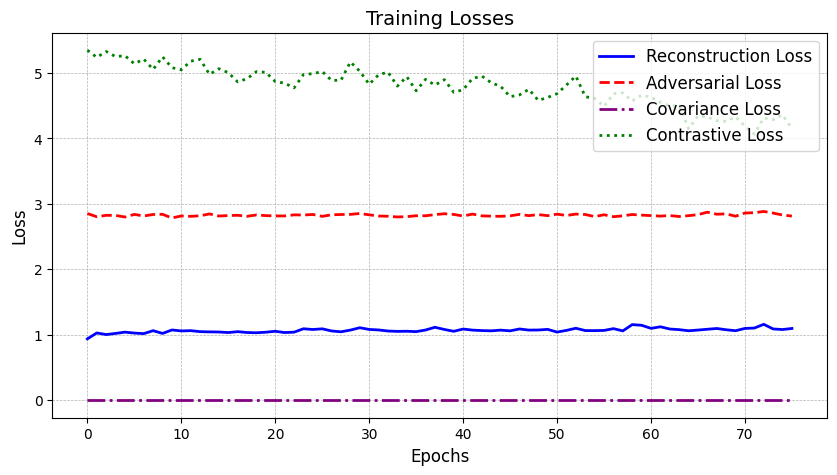

In [17]:
plt.figure(figsize=(10, 5))

# Plot both reconstruction and adversarial losses with different colors
plt.plot(reconstruction_losses, label='Reconstruction Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(adversarial_losses, label='Adversarial Loss', color='red', linestyle='--', linewidth=2)
plt.plot(cov_losses, label='Covariance Loss', color='purple', linestyle='-.', linewidth=2)
plt.plot(contra_losses, label='Contrastive Loss', color='green', linestyle=':', linewidth=2)

# Title and labels
plt.title(f"Training Losses", fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add a grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', fontsize=12)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


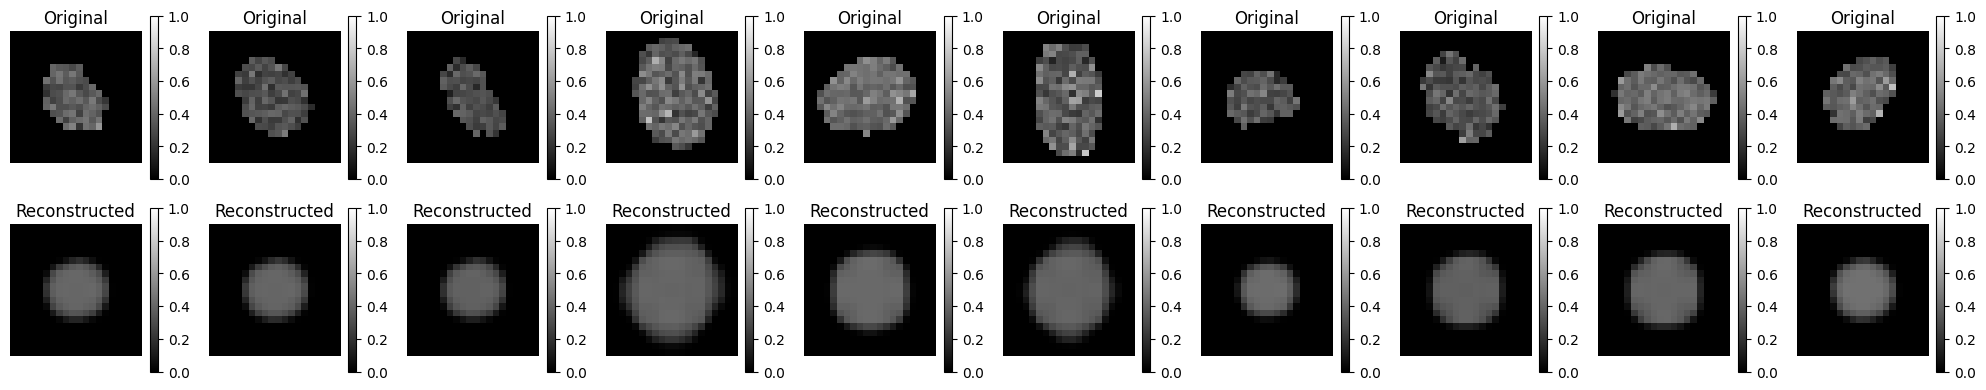

In [18]:
z_imgs = encoder.predict(train_images_augmented[:,0,:,:])
recon_imgs = decoder.predict(z_imgs)

reconstruction_images(train_images_augmented[:,0,:,:], recon_imgs)

Top correlated features: 1, 0


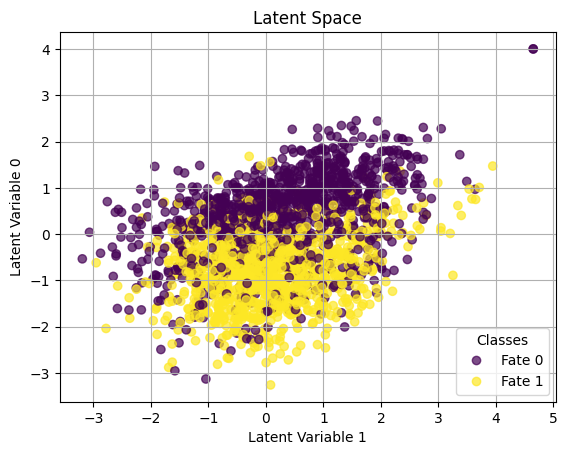

In [19]:
visualize_latent_space(z_imgs, train_labels_augmented, 0)

#### 3. Classify with MLP 

In [20]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
}

In [21]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

In [24]:
tf.keras.utils.set_random_seed(config['seed'])

classifier = mlp_classifier(latent_dim=config['latent_dim']) #[:, [3, 8]] 

x_test = test_images[:,0,:,:]
y_test = test_labels
x_train = train_images_augmented[:,0,:,:]
y_train = train_labels_augmented
# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val, y_val)) # 

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_27 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7061 - loss: 0.5399 - val_accuracy: 0.6522 - val_loss: 0.6707
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.6976 - loss: 0.5477 - val_accuracy: 0.6449 - val_loss: 0.6557
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.7145 - loss: 0.5406 - val_accuracy: 0.6667 - val_loss: 0.6442
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.7079 - loss: 0.5634 - val_accuracy: 0.6739 - val_loss: 0.6322
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.7153 - loss: 0.5382 - val_accuracy: 0.6739 - val_loss: 0.6281
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.7191 - loss: 0.5518 - val_accuracy: 0.6812 - val_loss: 0.6251
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7155 - loss: 0.5364 - val_accuracy: 0.6884 - val_loss: 0.6246
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━

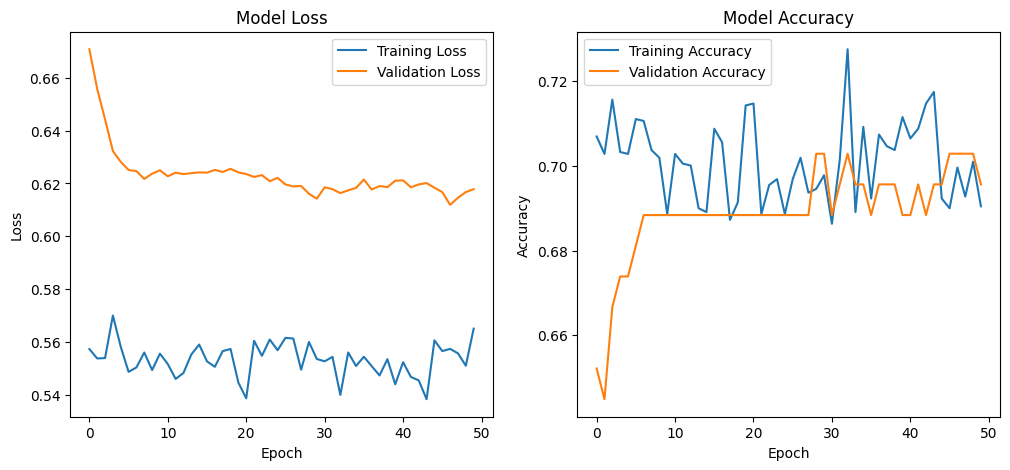

In [25]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[0.6036036 0.3963964]
 [0.25      0.75     ]]


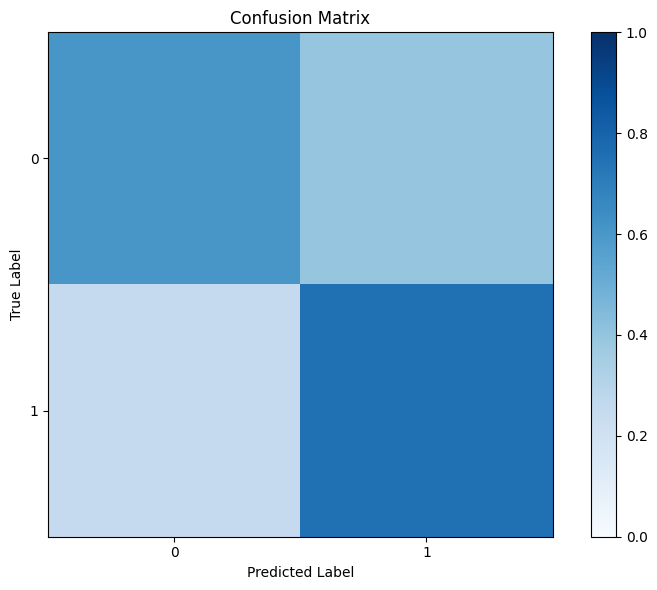

In [26]:
#### LAMBDA CONTRASTIVE LOSS = 4

num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#### 5. Temporal study

In [ ]:
### we need to go in range for all time points of the input data, and for each we do 3 different seeds ###

seeds = [42, 43, 44]
for seed in seeds:
    for i in range(11):
        x_train = train_images_augmented[:,i,:,:]
        y_train = train_labels_augmented
        x_test = test_images[:,i,:,:]
        y_test = test_labels

        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        results_ae = train_autoencoder(config_ae, x_train)
        encoder = results_ae['encoder']
        decoder = results_ae['decoder']
        discriminator = results_ae['discriminator']

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test)
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']


#### 6. Latent Space dimensionality study

### Only Adversarial Autoencoder

#### 1. Train Adversarial Autoencoder
With the same number of epochs and hyperparameters as before

#### 2. Evaluation 

### ImageNet classification